In [16]:
from arango import ArangoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sysdb = ArangoClient(hosts='http://localhost:8529')
arangoDb = sysdb.db('tcc_results', username=None, password=None)
collec = arangoDb.collection('tcc_results')

results = collec.find({}, limit=100000)
while results.has_more():
    ft = results.fetch()

figfolder = 'img'
figdpi = 100

df = pd.DataFrame(results.batch())

df['number_queries'] = df['number_queries'].astype('float64')
df['f1'] = df['f1'].astype('float64')
df['accuracy'] = df['accuracy'].astype('float64')
df['value'] = df['value'].astype('float64')
df['train_final_score'] = df['train_final_score'].astype('float64')
df['acc_cv_10'] = df['acc_cv_10'].astype('float64')
df['f1_cv_10'] = df['acc_cv_10'].astype('float64')
df = df.replace({'svc_C': {'': np.nan}, 'linear_svc_C': {'': np.nan}})
df['svc_C'] = df['svc_C'].astype('float64')
df['linear_svc_C'] = df['linear_svc_C'].astype('float64')

df['exp_run_type'] = df['tool']
df = df.replace({
    'exp_run_type': {
        'none': 'original', 'elastic': '+RI_elastic', 'arango': '+RI_arango', 'zettair': '+RI_zettair'},
    'db': { 
        'authorprof': 'author',
        'botgender': 'bot',
        'hyperpartisan': 'hyper'}
        })

time_queries_df = df.loc[(df['variable'] == 'TIME_QUERY') & (df['number_queries'] != '0')][['exp_id', 'db', 'solution_number','tool', 'number_queries', 'value']]



clf_acc_df = df.loc[(df['variable'] == 'CLF_ACC')]
clf_acc_df[['exp_id', 'db', 'solution_name', 'add_ir_variables', 'tool', 'accuracy', 'f1']]
# clf_acc_df['exp_run_type'] = clf_acc_df['tool']
# clf_acc_df = clf_acc_df.replace({'exp_run_type': 
#                          {'none': 'ORIGINAL', 'elastic': '+RI_ELASTIC', 'arango': '+RI_ARANGO', 'zettair': '+RI_ZETTAIR'}})
# clf_acc_df = clf_acc_df.replace({'exp_run_type': 
#                          {'none': 'original', 'elastic': '+RI_elastic', 'arango': '+RI_arango', 'zettair': '+RI_zettair'}})


time_queries_df.astype({'number_queries': 'int64', 'value': 'float'}).groupby(['db', 'tool', 'solution_number']).mean()

clf_acc_df.train_final_score.fillna(df.acc_cv_10 * df.f1_cv_10, inplace=True)
# clf_acc_df['train_final_score'].loc[] = clf_acc_df['acc_cv_10'] * clf_acc_df['f1_cv_10']
time_index = df.loc[(df['variable'] == 'TIME_INDEX')][['_key', 'exp_id', 'tool', 'index_type', 'db', 'db_name', 'value']]
time_query = df.loc[(df['variable'] == 'TIME_QUERY') & (df['number_queries'] != 0)][['exp_id', 'tool', 'execution_type', 'db', 'db_name', 'solution_name', 'number_queries', 'value']]

sel_1_bertha_columns = ['exp_id', 'solution_name',
                     'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'random_seed', 'add_ir_variables', 'ignore_first_result']
sel_1_bertha = clf_acc_df.loc[clf_acc_df['solution_name'] == '1_bertha'][sel_1_bertha_columns]

sel_4_tom_columns = ['exp_id', 'solution_name',
                     'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'svc_C', 'add_ir_variables', 'ignore_first_result']
# sel_4_tom = clf_acc_df.loc[clf_acc_df.groupby('exp_id')['train_final_score'].idxmax().dropna()][sel_4_tom_columns]
sel_4_tom = clf_acc_df.loc[clf_acc_df['solution_name'] == '4_tom'][sel_4_tom_columns]
# sel_2_daneshvar18 = clf_acc_df.loc[(clf_acc_df['solution_name'] == '2_daneshvar18') & (clf_acc_df['add_ir_variables'].isin([False, 'false', 'False']))][['exp_id', 'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'linear_svc_C', 'add_ir_variables', 'ignore_first_result']]
sel_2_daneshvar18_columns = ['exp_id', 'classifier', 'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'linear_svc_C', 'add_ir_variables', 'exp_run_type', 
                             'ignore_first_result', 'perform_dimentionality_reduction', 'use_only_ir_variables', 'use_scaler']
sel_2_daneshvar18 = clf_acc_df.loc[(clf_acc_df['solution_name'] == '2_daneshvar18')][sel_2_daneshvar18_columns]

/home/ruan/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/ruan/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Desempenho das ferramentas de armazenamento e indexação

### TIME_INDEX

In [17]:
selected = time_index.loc[(time_index['exp_id'] == '2020-01-04 15:25:18.500445') & time_index['db'].isin(['authorprof', 'hyperpartisan', 'author', 'hyper'])]
selected['ms_per_doc'] = selected['value']/np.concatenate((np.full((5, 1), 300000), np.full((5, 1), 645)) ).ravel() * 1000
selected = selected.drop(['exp_id'], axis=1)
selected
# ax = selected.plot.bar(x='db', y='value', rot=0)

/home/ruan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,_key,tool,index_type,db,db_name,value,ms_per_doc
24,20200104-153346.175728,arango,normal,author,authorprof,507.469449,1.691565
25,20200104-153417.547282,arango,bulk,author,authorprof_bulk,31.288749,0.104296
26,20200104-154353.061978,elastic,normal,author,authorprof,575.421832,1.918073
27,20200104-154410.726817,elastic,bulk,author,authorprof_bulk,17.610606,0.058702
28,20200104-154413.092359,zettair,bulk,author,authorprof_bulk,2.292951,0.007643
34,20200104-161010.226321,arango,normal,hyper,hyperpartisan,2.178453,3.377446
35,20200104-161011.072530,arango,bulk,hyper,hyperpartisan_bulk,0.755646,1.171545
36,20200104-161012.794293,elastic,normal,hyper,hyperpartisan,1.712412,2.654903
37,20200104-161013.141875,elastic,bulk,hyper,hyperpartisan_bulk,0.342446,0.530924
38,20200104-161013.341868,zettair,bulk,hyper,hyperpartisan_bulk,0.192181,0.297955


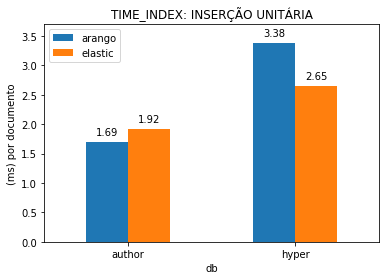

In [18]:
normal_index = selected.loc[selected['index_type'] == 'normal'].drop(['_key', 'db_name', 'index_type'], axis=1)
normal_index.set_index(['db', 'tool'], inplace=True)
ax = normal_index.unstack().plot(kind='bar', y='ms_per_doc')
plt.title('TIME_INDEX: INSERÇÃO UNITÁRIA')
plt.ylabel('(ms) por documento')
plt.legend(loc='upper left')
plt.xticks(rotation=0)
plt.ylim(0.0, 3.7)
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    zoom = 2
# w, h = ax.get_size_inches()
# ax.set_size_inches(w * zoom, h * zoom)
figname = 'time-index-individual'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [19]:
bulk_index = selected.loc[selected['index_type'] == 'bulk'].drop(['_key', 'db_name', 'index_type'], axis=1)
bulk_index.set_index(['db', 'tool'], inplace=True)
bulk_index

value  ms_per_doc
db     tool                          
author arango   31.288749    0.104296
       elastic  17.610606    0.058702
       zettair   2.292951    0.007643
hyper  arango    0.755646    1.171545
       elastic   0.342446    0.530924
       zettair   0.192181    0.297955

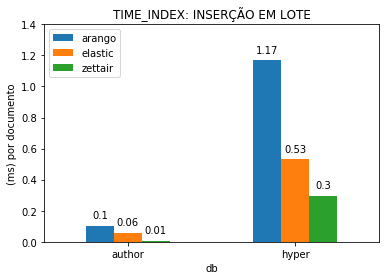

In [20]:
bulk_index = selected.loc[selected['index_type'] == 'bulk'].drop(['_key', 'db_name', 'index_type'], axis=1)
bulk_index.set_index(['db', 'tool'], inplace=True)
ax = bulk_index.unstack().plot(kind='bar', y='ms_per_doc')
plt.title('TIME_INDEX: INSERÇÃO EM LOTE')
plt.ylabel('(ms) por documento')
plt.legend(loc='upper left')
plt.xticks(rotation=0)
plt.ylim(0.0, 1.4)
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'time-index-bulk'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [21]:
time_index= time_index.replace({'exp_id': {'20200104-153346.175728': 'ArangoB1', '2020-01-04 13:44:18.742265': 'ElasticB1', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})

### TIME_QUERY

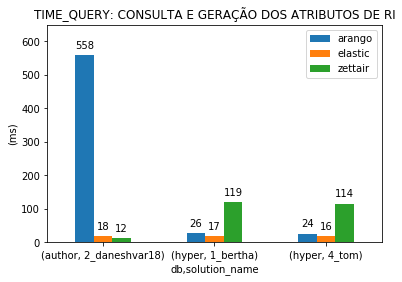

In [22]:
selected = time_query.loc[(time_query['db'].isin(['authorprof', 'hyperpartisan', 'author', 'hyper'])) & (time_query['value'] != 'nan') & (time_query['execution_type'] != 'testing')].dropna(subset=['value']).drop(['db_name'], axis=1)
selected = selected.loc[selected['exp_id'].isin(['2020-01-06 13:03:42.329566', '2020-01-04 20:34:49.785117', '2020-01-08 01:38:09.511822', '2020-01-13 02:36:12.053429', '2020-01-04 18:34:02.470777', '2020-01-08 01:26:00.716361', '2020-01-05 20:01:49.675055', '2020-01-04 21:06:54.353526', '2020-01-08 02:32:14.456408'])]
selected.sort_values(by=['db', 'tool'], inplace=True)
selected.set_index(['db', 'solution_name', 'tool'], inplace=True)
# selected.loc[(selected['tool'] == 'zettair')]
selected['ms_per_query'] = selected['value'] * 1000
ax = selected.unstack().plot(kind='bar', y='ms_per_query')
plt.title('TIME_QUERY: CONSULTA E GERAÇÃO DOS ATRIBUTOS DE RI')
plt.ylabel('(ms)')
plt.legend(loc='upper right')
plt.xticks(rotation=0)
plt.ylim(0.0, 650)
for p in ax.patches:
    ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'time-query'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight', dpi=100)

## Desempenho dos classificadores com atributos de RI

### DB_AUTHORPROF - SOLUTION 1 - 2_daneshvar18

In [23]:
# sel_2_daneshvar18[-305:-285]
sel_2_daneshvar18.loc[sel_2_daneshvar18.groupby('exp_id')['f1'].idxmax().dropna()]

,exp_id,classifier,train_final_score,accuracy,f1,tool,top_k,linear_svc_C,add_ir_variables,exp_run_type,ignore_first_result,perform_dimentionality_reduction,use_only_ir_variables,use_scaler
68,2020-01-04 23:56:36.242484,NaN,NaN,0.822105,0.820785,elastic,100,NaN,false,+RI_elastic,NaN,NaN,NaN,NaN
72,2020-01-05 00:08:39.282482,NaN,NaN,0.673684,0.657459,elastic,100,NaN,true,+RI_elastic,NaN,NaN,NaN,NaN
78,2020-01-05 20:01:49.675055,NaN,NaN,0.698421,0.725968,zettair,100,NaN,true,+RI_zettair,NaN,NaN,NaN,NaN
82,2020-01-06 13:03:42.329566,NaN,NaN,0.726316,0.750240,arango,100,NaN,true,+RI_arango,NaN,NaN,NaN,NaN
86,2020-01-07 08:44:13.089672,NaN,NaN,0.713684,0.752502,elastic,100,NaN,true,+RI_elastic,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29194,2020-01-27 09:26:29.916209,LinearSVC,0.752267,0.827368,0.826455,zettair,100,3.800000,True,+RI_zettair,True,True,False,True
29602,2020-01-27 10:00:09.195423,LinearSVC,0.747648,0.823158,0.820896,elastic,100,3.400000,True,+RI_elastic,True,True,False,True
30082,2020-01-27 10:13:17.104934,LinearSVC,0.755740,0.826316,0.823529,arango,100,6.600000,True,+RI_arango,True,True,False,True
30404,2020-01-27 11:03:55.256768,LinearSVC,0.707281,0.824211,0.823093,zettair,1000,1.900000,True,+RI_zettair,True,True,False,True


In [9]:
ress = sel_2_daneshvar18.loc[(sel_2_daneshvar18.groupby('exp_id')['accuracy'].idxmax().dropna())]
ress2 = ress.loc[(ress['top_k'] == '100')]
ress = ress.loc[(ress['top_k'] == '100') & (ress['linear_svc_C'] == 1.0)]
sel_2_daneshvar18.loc[sel_2_daneshvar18['exp_id'].isin(['2020-01-23 12:42:28.234044'])]

,exp_id,classifier,train_final_score,accuracy,f1,tool,top_k,linear_svc_C,add_ir_variables,exp_run_type,ignore_first_result,perform_dimentionality_reduction,use_only_ir_variables,use_scaler
11084,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.707895,0.746460,none,100,1.000000e-06,False,original,True,True,False,False
11086,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.710000,0.745966,none,100,1.150000e-05,False,original,True,True,False,False
11088,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.711053,0.745480,none,100,2.190000e-05,False,original,True,True,False,False
11090,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.710000,0.743124,none,100,3.240000e-05,False,original,True,True,False,False
11092,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.708947,0.740984,none,100,4.290000e-05,False,original,True,True,False,False
11094,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.711579,0.741996,none,100,5.340000e-05,False,original,True,True,False,False
11096,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.710000,0.739233,none,100,6.380000e-05,False,original,True,True,False,False
11098,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.710526,0.738095,none,100,7.430000e-05,False,original,True,True,False,False
11100,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.712105,0.737901,none,100,8.480000e-05,False,original,True,True,False,False
11102,2020-01-23 12:42:28.234044,LinearSVC,NaN,0.714211,0.739068,none,100,9.530000e-05,False,original,True,True,False,False


In [10]:
top_k_100_exp_ids = ['2020-01-23 18:26:07.375789', '2020-01-23 21:20:45.677147', '2020-01-23 21:41:38.722074', '2020-01-24 16:40:36.117670']
# top_k_100_exp_ids = ['2020-01-22 00:46:46.165082', '2020-01-22 09:44:59.320466', '2020-01-23 10:52:26.122222']
# top_k_100_exp_ids = ['2020-01-23 18:26:07.375789', '2020-01-23 21:20:45.677147', '2020-01-23 21:41:38.722074', '2020-01-24 16:40:36.117670']
cre_both = df.loc[(df['variable'].isin(['CLF_ACC', 'CLF_F1']))]
cre_both = cre_both.loc[cre_both['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['linear_svc_C'])
cre_both = cre_both.loc[(cre_both['linear_svc_C'] <= 10) & (cre_both['linear_svc_C'] >= 0)]
cre = clf_acc_df.loc[clf_acc_df['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['linear_svc_C'])
cre = cre.loc[(cre['linear_svc_C'] <= 10) & (cre['linear_svc_C'] >= 0)]

# cre = cre.replace({'exp_id': {'2020-01-21 01:11:16.682270': 'ORIGINAL', '2020-01-20 11:56:27.013101': '+RI_ELASTIC', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})
sel_dict = {'exp_id': {'2020-01-23 18:26:07.375789': 'original', '2020-01-23 21:20:45.677147': '+RI_elastic', '2020-01-23 21:41:38.722074': '+RI_zettair', '2020-01-24 16:40:36.117670': '+RI_arango'}}
cre_both = cre_both.replace(sel_dict)
cre = cre.replace(sel_dict)
cre

,_key,_id,_rev,exp_id,variable,index_type,db,tool,db_name,value,...,acc_train,acc_cv_10,f1_cv_10,use_scaler,use_only_ir_variables,scaler,use_scaler_only_ir,scaler_min,scaler_max,exp_run_type
17993,20200123-184455.345007,tcc_results/20200123-184455.345007,_Z7PbefG---,original,CLF_ACC,NaN,author,none,authorprof_bulk,0.822105,...,NaN,0.827333,0.827333,False,False,,False,NaN,NaN,original
18010,20200123-213225.006383,tcc_results/20200123-213225.006383,_Z7R00cC---,+RI_elastic,CLF_ACC,NaN,author,elastic,authorprof_bulk,0.744737,...,NaN,0.824333,0.824333,False,False,,False,NaN,NaN,+RI_elastic
18012,20200123-215301.530341,tcc_results/20200123-215301.530341,_Z7SHr8G---,+RI_zettair,CLF_ACC,NaN,author,zettair,authorprof_bulk,0.723684,...,NaN,0.819000,0.819000,False,False,,False,NaN,NaN,+RI_zettair
19556,20200124-165426.936883,tcc_results/20200124-165426.936883,_Z7icsbW---,+RI_arango,CLF_ACC,NaN,author,arango,authorprof_bulk,0.716316,...,NaN,0.723667,0.723667,False,False,,False,NaN,NaN,+RI_arango


In [11]:
sol_2_daneshvar18_table = cre[['db', 'solution_name', 'variable', 'exp_run_type', 'accuracy', 'f1']].set_index(['db', 'solution_name', 'variable', 'exp_run_type' ])
sol_2_daneshvar18_table

sol_2_daneshvar18_table_full = cre_both[['db', 'solution_name', 'variable', 'exp_run_type', 'value']]
sol_2_daneshvar18_table_full.sort_values(by=['db', 'solution_name', 'variable'], inplace=True)
sol_2_daneshvar18_table_full = sol_2_daneshvar18_table_full.set_index(['db', 'solution_name', 'variable', 'exp_run_type' ])
sol_2_daneshvar18_table_full['value'] *= 100
sol_2_daneshvar18_table_full

/home/ruan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


NameError: name 'c' is not defined

In [0]:
from matplotlib.ticker import PercentFormatter
fin1 = sol_2_daneshvar18_table.copy()
fin1['accuracy'] *= 100
fin1['f1'] *= 100
fin_both = sol_2_daneshvar18_table_full.copy()

In [0]:
fin1['accuracy'].append(fin1['f1'])

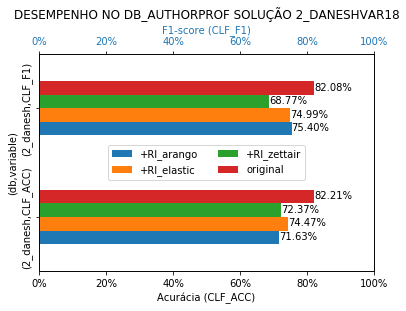

In [14]:
# plt.style.use('default')
ax = fin_both.unstack().plot(kind='barh', y='value')
ax.xaxis.set_major_formatter(PercentFormatter())
plt.title('DESEMPENHO NO DB_AUTHORPROF SOLUÇÃO 2_DANESHVAR18')
ax.legend(loc='center', ncol=2) #, bbox_to_anchor=(-0.02, 0.98))
for p in ax.patches:
    # ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))
    # ax2.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))

plt.yticks(rotation=90, va="center")
ax.set_xlabel('Acurácia (CLF_ACC)')  # we already handled the x-label with ax1
ax.set_ylabel('(db,variable)')
ax.set_yticklabels(['(2_danesh,CLF_ACC)', '(2_danesh,CLF_F1)'])

ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis

ax2.xaxis.set_major_formatter(PercentFormatter())
color = 'tab:blue'
# ax2.plot(t, data2, color=color)
ax.set_xlim(0.0, 100)
ax2.set_xlim(0.0, 100)
ax2.set_xlabel('F1-score (CLF_F1)', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='x', labelcolor=color)
    # ax.annotate(p.get_height().astype('int64'), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.yticks(rotation=90, va="center")
figname = 'clf-bars-authorprof'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

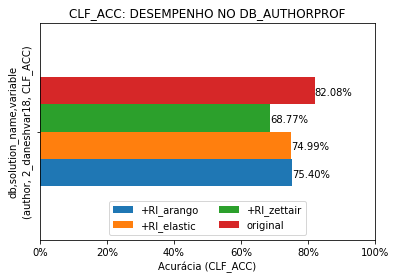

In [15]:
ax = fin1.unstack().plot(kind='barh', y='f1')
ax.xaxis.set_major_formatter(PercentFormatter())
plt.title('CLF_ACC: DESEMPENHO NO DB_AUTHORPROF')
plt.xlabel('Acurácia (CLF_ACC)')
plt.legend(loc='lower center', ncol=2) #, bbox_to_anchor=(-0.02, 0.98))
plt.yticks(rotation=90, va="center")
plt.xlim(0.0, 100)
for p in ax.patches:
    # ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))

    # ax.annotate(p.get_height().astype('int64'), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'clf-acc-bars-authorprof'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

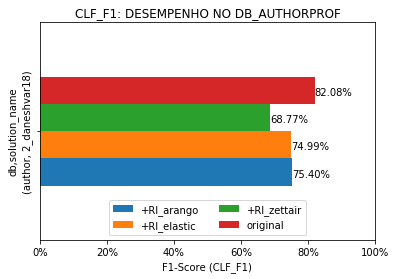

In [573]:
ax = fin1.unstack().plot(kind='barh', y='f1')
ax.xaxis.set_major_formatter(PercentFormatter())
plt.title('CLF_F1: DESEMPENHO NO DB_AUTHORPROF')
plt.xlabel('F1-Score (CLF_F1)')
plt.legend(loc='lower center', ncol=2) #, bbox_to_anchor=(-0.02, 0.98))
plt.yticks(rotation=90, va="center")
plt.xlim(0.0, 100)
for p in ax.patches:
    # ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))

    # ax.annotate(p.get_height().astype('int64'), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'clf-f1-bars-authorprof'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [574]:
ploting = sel_2_daneshvar18.loc[sel_2_daneshvar18.groupby('exp_id')['accuracy'].idxmax().dropna()]
# ploting = sel_2_daneshvar18
ploting_ir_only = ploting.loc[(ploting['top_k'] == '100') & (ploting['use_only_ir_variables'].isin([True, 'true']))]
ploting_ir_only = sel_2_daneshvar18.loc[sel_2_daneshvar18['exp_id'].isin(ploting_ir_only['exp_id'])]
ploting_ir_only['exp_id'] = ploting_ir_only['exp_id'] + ploting_ir_only['tool']
ploting = ploting.loc[(ploting['top_k'] == '100') & (ploting['perform_dimentionality_reduction'].isin([True, 'true']))]
# ploting = ploting.loc[ploting['use_scaler'] == False]
ploting = sel_2_daneshvar18.loc[sel_2_daneshvar18['exp_id'].isin(ploting['exp_id'])]

ploting = ploting.dropna(subset=['linear_svc_C'])
# ploting['linear_svc_C'] = ploting.linear_svc_C.map(lambda x: '{:.8f}'.format(x)) 
ploting = ploting.loc[(ploting['linear_svc_C'].astype('float64') <= 10) & (ploting['linear_svc_C'].astype('float64') >= 0.00001)]
# ploting

/home/ruan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [575]:
ploting.f1.unique()
# ids_to_plot = ['2020-01-26 23:34:00.956503']
ids_to_plot = [
    '2020-01-23 12:42:28.234044',
    '2020-01-26 23:34:00.956503', 
    '2020-01-26 23:51:58.664099']
ids_after_dim_reduc_no_scaler = [
    # '2020-01-23 12:42:28.234044',
    '2020-01-26 23:34:00.956503',
    '2020-01-27 00:14:21.347486',
    '2020-01-27 00:40:43.988698',
    '2020-01-27 01:31:03.115582']
ids_after_dim_reduc_with_scaler = [
    # '2020-01-23 12:42:28.234044',
    '2020-01-26 23:34:00.956503',
    '2020-01-27 02:15:42.490250',
    '2020-01-27 02:33:12.121908',
    '2020-01-27 02:43:04.626085',
    # '2020-01-27 03:22:17.199563',
    # '2020-01-27 03:12:22.430471',
    # '2020-01-27 03:03:20.931245'
    ]
ids_after_dim_reduc_with_scaler_alt = [
    # '2020-01-23 12:42:28.234044',
    '2020-01-26 23:34:00.956503',
    '2020-01-27 05:40:14.548510',
    '2020-01-27 04:50:04.038730',
    '2020-01-27 06:07:06.564672'
]
    
ploting_with_scaler = ploting.loc[ploting['exp_id'].isin(ids_after_dim_reduc_with_scaler)]
ploting_with_scaler_alt = ploting.loc[ploting['exp_id'].isin(ids_after_dim_reduc_with_scaler_alt)]
ploting_no_scaler = ploting.loc[ploting['exp_id'].isin(ids_after_dim_reduc_no_scaler)]
replace_dict = {'exp_id': {
    '2020-01-26 23:34:00.956503': 'original',
    '2020-01-27 00:14:21.347486': '+RI_arango',
    '2020-01-27 00:40:43.988698': '+RI_elastic',
    '2020-01-27 01:31:03.115582': '+RI_zettair',
    '2020-01-27 02:15:42.490250': '+RI_arango-MinMaxScaler',
    '2020-01-27 02:33:12.121908': '+RI_elastic-MinMaxScaler',
    '2020-01-27 02:43:04.626085': '+RI_zettair-MinMaxScaler',
    '2020-01-27 06:07:06.564672': '+RI_arango-MinMaxScaler',
    '2020-01-27 05:40:14.548510': '+RI_elastic-MinMaxScaler',
    '2020-01-27 04:50:04.038730': '+RI_zettair-MinMaxScaler',
    # '2020-01-27 03:22:17.199563': '+RI_arango-MaxAbsScaler',
    # '2020-01-27 03:12:22.430471': '+RI_elastic-MaxAbsScaler',
    # '2020-01-27 03:03:20.931245': '+RI_zettair-MaxAbsScaler'
    }}
ploting_no_scaler = ploting_no_scaler.replace(replace_dict)
ploting_with_scaler = ploting_with_scaler.replace(replace_dict)
ploting_with_scaler_alt = ploting_with_scaler_alt.replace(replace_dict)

In [576]:
ploting_with_scaler.loc[ploting_with_scaler.groupby('exp_id')['accuracy'].idxmax()]

,exp_id,classifier,train_final_score,accuracy,f1,tool,top_k,linear_svc_C,add_ir_variables,exp_run_type,ignore_first_result,perform_dimentionality_reduction,use_only_ir_variables,use_scaler
21662,+RI_arango-MinMaxScaler,LinearSVC,NaN,0.813158,0.810059,arango,100,1.6,True,+RI_arango,True,True,False,True
22054,+RI_elastic-MinMaxScaler,LinearSVC,NaN,0.808947,0.810444,elastic,100,0.4,True,+RI_elastic,True,True,False,True
22474,+RI_zettair-MinMaxScaler,LinearSVC,NaN,0.816842,0.817227,zettair,100,0.6,True,+RI_zettair,True,True,False,True
20350,original,LinearSVC,NaN,0.822105,0.820785,none,100,1.0,False,original,False,True,False,False


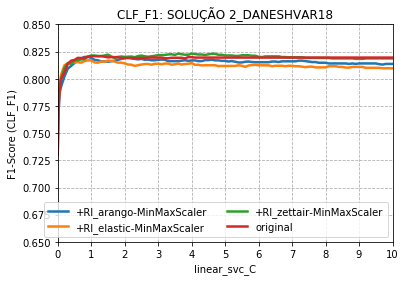

In [545]:
ax = ploting_with_scaler_alt.set_index('linear_svc_C').groupby('exp_id').f1.plot(legend=True, lw=2.5)
plt.ylabel('F1-Score (CLF_F1)')
plt.title('CLF_F1: SOLUÇÃO 2_DANESHVAR18')
ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.86)
# ax[0].set_xlim(0.0, 0.1)
plt.legend(loc='lower right', ncol=2) 
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_xlim(0, 10)
ax[0].set_ylim(0.65, 0.85)
figname = 'clf-f1-2-daneshvar18'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

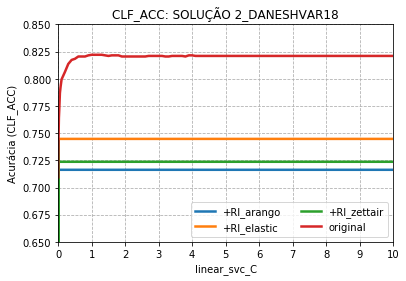

In [546]:
ax = ploting_no_scaler.set_index('linear_svc_C').groupby('exp_id').accuracy.plot(legend=True, lw=2.5)
plt.ylabel('Acurácia (CLF_ACC)')
plt.title('CLF_ACC: SOLUÇÃO 2_DANESHVAR18')
ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.86)
# ax[0].set_xlim(0.0, 0.1)
plt.legend(loc='lower right', ncol=2) 
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_xlim(0, 10)
ax[0].set_ylim(0.65, 0.85)
figname = 'clf-acc-2-daneshvar18'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [527]:
best_values = ploting_with_scaler_alt.loc[ploting_with_scaler_alt.groupby('tool').idxmax()['f1']]
best_values = best_values[['exp_run_type', 'linear_svc_C', 'accuracy', 'f1']]
best_values

,exp_run_type,linear_svc_C,accuracy,f1
27056,+RI_arango,0.9,0.822632,0.820267
26640,+RI_elastic,0.9,0.818421,0.816976
20350,original,1.0,0.822105,0.820785
26278,+RI_zettair,3.6,0.823684,0.823219


In [ ]:
best_values = ploting_no_scaler.loc[ploting_no_scaler.groupby('tool').idxmax()['f1']]
best_values = best_values[['exp_run_type', 'linear_svc_C', 'accuracy', 'f1']]
best_values

Solução 2_DANESHVAR18 com escalonamento das variáveis de RI

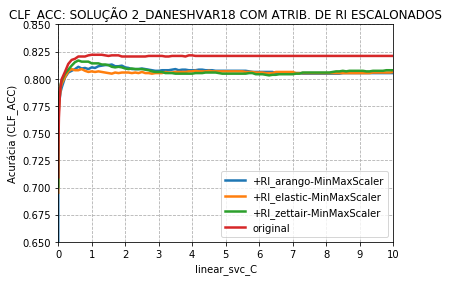

In [464]:
ax = ploting_with_scaler.set_index('linear_svc_C').groupby('exp_id').accuracy.plot(legend=True, lw=2.5)
plt.ylabel('Acurácia (CLF_ACC)')
plt.title('CLF_ACC: SOLUÇÃO 2_DANESHVAR18 COM ATRIB. DE RI ESCALONADOS')
ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.86)
plt.legend(loc='lower right') 
ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_xlim(0.0, 1.5)
ax[0].set_xlim(0, 10)
# ax[0].set_ylim(0.75, 0.86)
ax[0].set_ylim(0.65, 0.85)
figname = 'clf-acc-2-daneshvar18-ir-scaled'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

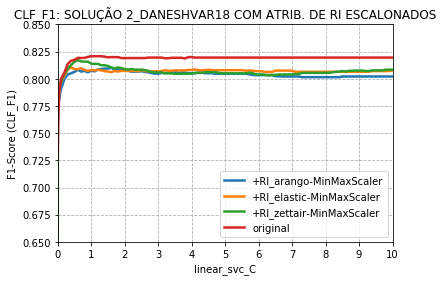

In [443]:
ax = ploting_with_scaler.set_index('linear_svc_C').groupby('exp_id').f1.plot(legend=True, lw=2.5)
plt.ylabel('F1-Score (CLF_F1)')
plt.title('CLF_F1: SOLUÇÃO 2_DANESHVAR18 COM ATRIB. DE RI ESCALONADOS')
ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.86)
plt.legend(loc='lower right') 
ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_xlim(0.0, 1.5)
ax[0].set_xlim(0, 10)
# ax[0].set_ylim(0.75, 0.86)
ax[0].set_ylim(0.65, 0.85)
figname = 'clf-f1-2-daneshvar18-ir-scaled'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [416]:
best_values = ploting_with_scaler.loc[ploting_with_scaler.groupby('tool').idxmax()['f1']]

best_values = best_values[['exp_run_type', 'linear_svc_C', 'accuracy', 'f1']]
best_values

,exp_run_type,linear_svc_C,accuracy,f1
21662,+RI_arango,1.6,0.813158,0.810059
22054,+RI_elastic,0.4,0.808947,0.810444
20350,original,1.0,0.822105,0.820785
22474,+RI_zettair,0.6,0.816842,0.817227


### DB_HYPERPARTISAN - SOLUTION 1 - 1_bertha

In [417]:
sel_1_bertha.loc[sel_1_bertha['top_k'] == '100']
df.columns
sel_1_bertha.dropna(subset=['random_seed'])

,exp_id,solution_name,train_final_score,accuracy,f1,tool,top_k,random_seed,add_ir_variables,ignore_first_result
278,2020-01-18 10:14:02.717502,1_bertha,NaN,0.827907,0.767296,arango,40,42.0,True,True
282,2020-01-18 10:45:45.051194,1_bertha,NaN,0.846512,0.784314,elastic,40,42.0,True,True
285,2020-01-18 10:45:45.051194,1_bertha,NaN,0.823256,0.762500,elastic,40,42.0,True,True
290,2020-01-18 11:27:34.212293,1_bertha,NaN,0.869767,0.822785,zettair,40,42.0,True,True
294,2020-01-18 12:02:18.164681,1_bertha,NaN,0.846512,0.789809,zettair,100,42.0,True,True
298,2020-01-18 12:51:51.469046,1_bertha,NaN,0.860465,0.800000,elastic,100,42.0,True,True
302,2020-01-18 13:29:12.379060,1_bertha,NaN,0.865116,0.810458,arango,100,42.0,True,True
17996,2020-01-23 18:09:16.266875,1_bertha,0.781395,0.813953,0.761905,none,100,42.0,False,True
18000,2020-01-23 19:03:17.718672,1_bertha,0.774419,0.865116,0.810458,arango,100,42.0,True,True
18004,2020-01-23 19:39:21.506369,1_bertha,0.774419,0.860465,0.800000,elastic,100,42.0,True,True


In [418]:
# top_k = 100, exp ids
top_k_100_exp_ids = ['2020-01-23 18:09:16.266875', '2020-01-23 19:03:17.718672', '2020-01-23 19:39:21.506369', '2020-01-23 20:21:32.494356']

# df_4_tom = clf_acc_df.loc[(clf_acc_df['solution_name'] == '4_tom')]
# cre = df_4_tom.loc[df_4_tom['ir_top_k'].isin(['100', 100])].dropna(subset=['svc_C'])

cre = clf_acc_df.loc[clf_acc_df['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['train_final_score'])

# cre = cre[6:106]
cre['f1'] = cre['f1'].astype('float64')
cre['accuracy'] = cre['accuracy'].astype('float64')
cre['svc_C'] = cre['svc_C'].astype('float64')
# cre = cre.replace({'exp_id': {'2020-01-21 01:11:16.682270': 'ORIGINAL', '2020-01-20 11:56:27.013101': '+RI_ELASTIC', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})
cre = cre.replace({'exp_id': {'2020-01-23 18:09:16.266875': 'ORIGINAL', '2020-01-23 19:03:17.718672': '+RI_ELASTIC', '2020-01-23 19:39:21.506369': '+RI_ARANGO', '2020-01-23 20:21:32.494356	': '+RI_ZETTAIR'}})
cre = cre.replace({
    'db': {'hyperpartisan': 'hyper'}
                    })

In [419]:
cre.columns

Index(['_key', '_id', '_rev', 'exp_id', 'variable', 'index_type', 'db', 'tool',
       'db_name', 'value', 'indexName', 'bm25_b', 'bm25_k1', 'bm25_k3',
       'top_k', 'add_ir_variables', 'solution_number', 'solution_name',
       'execution_type', 'train_input', 'number_queries', 'test_input',
       'saved_model1', 'saved_model2', 'saved_model3', 'train_epochs', 'TP',
       'FP', 'TN', 'FN', 'accuracy', 'f1', 'train_data_folder',
       'test_data_folder', 'ir_top_k', 'ignore_first_result', 'random_seed',
       'train_final_score', 'classifier', 'linear_svc_C',
       'linear_svc_max_iter', 'perform_dimentionality_reduction',
       'ir_variables_before_dim_reduction', 'svc_C', 'svc_max_iter',
       'acc_train', 'acc_cv_10', 'f1_cv_10', 'use_scaler',
       'use_only_ir_variables', 'scaler', 'use_scaler_only_ir',
       'exp_run_type'],
      dtype='object')

In [420]:
# , 'saved_model1', 'saved_model2', 'saved_model3',
sol_1_bertha_table = cre[['db', 'solution_name', 'exp_run_type', 'accuracy', 'f1']].set_index(['db', 'solution_name', 'exp_run_type'])
sol_1_bertha_table

accuracy        f1
db    solution_name exp_run_type                    
hyper 1_bertha      original      0.813953  0.761905
                    +RI_arango    0.865116  0.810458
                    +RI_elastic   0.860465  0.800000
                    +RI_zettair   0.846512  0.789809

In [421]:
# ax = cre.set_index('svc_C').groupby('exp_id').f1.plot(legend=True)
# plt.ylabel('CLF_F1')
# plt.title('DB_HYPERPARTISAN: SOLUTION 1')
# ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.80)

# # ax[0].lines[0].set_dashes([1, 1, 10, 2])
# # ax[0].lines[1].set_dashes([1, 2 ])
# # ax[0].lines[2].set_dashes([1, 2 ])
# # ax[0].lines[3].set_dashes([1, 8 ])

### DB_HYPERPARTISAN - SOLUTION 2 - 4_tom

In [422]:
sel_4_tom.loc[(sel_4_tom['svc_C'] == 0.9) & (sel_4_tom['ignore_first_result'] == True)]

,exp_id,solution_name,train_final_score,accuracy,f1,tool,top_k,svc_C,add_ir_variables,ignore_first_result
3488,2020-01-20 11:56:27.013101,4_tom,0.636284,0.809302,0.696296,elastic,100,0.9,True,True
3709,2020-01-20 12:03:17.206173,4_tom,0.632580,0.800000,0.681481,elastic,40,0.9,True,True
3930,2020-01-20 12:17:29.856689,4_tom,0.636284,0.800000,0.681481,arango,100,0.9,True,True
4151,2020-01-20 12:27:48.045190,4_tom,0.628886,0.804651,0.686567,arango,40,0.9,True,True
4372,2020-01-20 12:40:57.164582,4_tom,0.628886,0.800000,0.676692,zettair,100,0.9,True,True
4593,2020-01-20 16:01:00.318347,4_tom,0.632580,0.818605,0.711111,zettair,40,0.9,True,True
4814,2020-01-21 01:05:49.361354,4_tom,0.636284,0.809302,0.696296,zettair,200,0.9,True,True
7024,2020-01-21 02:03:22.702736,4_tom,0.632580,0.823256,0.724638,zettair,400,0.9,True,True
7245,2020-01-21 02:08:40.172328,4_tom,0.632580,0.809302,0.696296,arango,200,0.9,True,True
7466,2020-01-21 02:12:30.391032,4_tom,0.640000,0.795349,0.666667,arango,400,0.9,True,True


In [423]:
# sel_4_tom.loc[sel_4_tom['top_k'] == '100']
cre.loc[cre['svc_C'] == 0.9]

,_key,_id,_rev,exp_id,variable,index_type,db,tool,db_name,value,...,svc_C,svc_max_iter,acc_train,acc_cv_10,f1_cv_10,use_scaler,use_only_ir_variables,scaler,use_scaler_only_ir,exp_run_type


In [424]:
# top_k = 100, exp ids
top_k_100_exp_ids = ['2020-01-23 23:22:43.208790', '2020-01-23 23:33:52.462655', '2020-01-24 00:29:03.607760', '2020-01-24 00:43:32.915599']
# top_k_100_exp_ids = ['2020-01-21 01:11:16.682270', '2020-01-20 11:56:27.013101', '2020-01-20 12:17:29.856689', '2020-01-20 12:40:57.164582']

# df_4_tom = clf_acc_df.loc[(clf_acc_df['solution_name'] == '4_tom')]
# cre = df_4_tom.loc[df_4_tom['ir_top_k'].isin(['100', 100])].dropna(subset=['svc_C'])

cre = clf_acc_df.loc[clf_acc_df['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['svc_C'])
cre['svc_C'] = cre.svc_C.map(lambda x: '{:.8f}'.format(x)) 
cre = cre.loc[(cre['svc_C'].astype('float64') <= 10) & (cre['svc_C'].astype('float64') >= 0.1)]

# cre = cre[6:106]
cre['f1'] = cre['f1'].astype('float64')
cre['accuracy'] = cre['accuracy'].astype('float64')
cre['svc_C'] = cre['svc_C'].astype('float64')
# cre = cre.replace({'exp_id': {'2020-01-21 01:11:16.682270': 'ORIGINAL', '2020-01-20 11:56:27.013101': '+RI_ELASTIC', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})
cre = cre.replace({'exp_id': {'2020-01-23 23:22:43.208790': 'original',
 '2020-01-23 23:33:52.462655': '+RI_arango',
 '2020-01-24 00:29:03.607760': '+RI_elastic',
 '2020-01-24 00:43:32.915599': '+RI_zettair'},
                    'db': {'hyperpartisan': 'hyper'}})
#  'classifier', 'svc_C',
cre = cre.loc[cre['_id'] != 'tcc_results/20200123-232321.988839']

sol_4_tom_table = cre.loc[cre['svc_C'] == 0.9][['db', 'solution_name', 'exp_run_type', 'accuracy', 'f1']].set_index(['db', 'solution_name', 'exp_run_type'])
sol_4_tom_table

accuracy        f1
db    solution_name exp_run_type                    
hyper 4_tom         original      0.809302  0.700730
                    +RI_arango    0.800000  0.681481
                    +RI_elastic   0.809302  0.696296
                    +RI_zettair   0.800000  0.676692

In [425]:
cre.loc[cre['f1'].idxmax()]
cre.loc[cre['f1_cv_10'].idxmax()]


_key                                             20200123-233503.217127
_id                                  tcc_results/20200123-233503.217127
_rev                                                        _Z7TlGJW---
exp_id                                                       +RI_arango
variable                                                        CLF_ACC
index_type                                                          NaN
db                                                                hyper
tool                                                             arango
db_name                                     hyperpartisan_split_42_bulk
value                                                          0.790698
indexName                                   hyperpartisan_split_42_bulk
bm25_b                                                             0.75
bm25_k1                                                             1.2
bm25_k3                                                         

In [426]:
from matplotlib.ticker import PercentFormatter
fin = sol_1_bertha_table.append(sol_4_tom_table)
fin['accuracy'] *= 100
fin['f1'] *= 100
fin.unstack()

accuracy                                            f1  \
exp_run_type        +RI_arango +RI_elastic +RI_zettair   original +RI_arango   
db    solution_name                                                            
hyper 1_bertha       86.511628   86.046512   84.651163  81.395349  81.045752   
      4_tom          80.000000   80.930233   80.000000  80.930233  68.148148   

                                                        
exp_run_type        +RI_elastic +RI_zettair   original  
db    solution_name                                     
hyper 1_bertha         80.00000   78.980892  76.190476  
      4_tom            69.62963   67.669173  70.072993

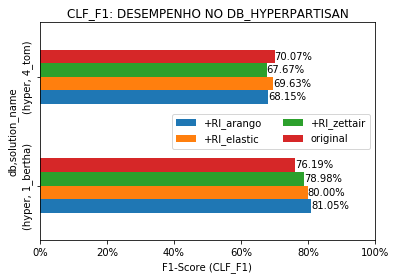

In [427]:
ax = fin.unstack().plot(kind='barh', y='f1')
ax.xaxis.set_major_formatter(PercentFormatter())
plt.title('CLF_F1: DESEMPENHO NO DB_HYPERPARTISAN')
plt.xlabel('F1-Score (CLF_F1)')
plt.legend(loc='best', ncol=2) #, bbox_to_anchor=(-0.02, 0.68))
plt.yticks(rotation=90, va="center")
plt.xlim(0.0, 100)
for p in ax.patches:
    # ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))

    # ax.annotate(p.get_height().astype('int64'), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'clf-f1-bars-hyperpartisan'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

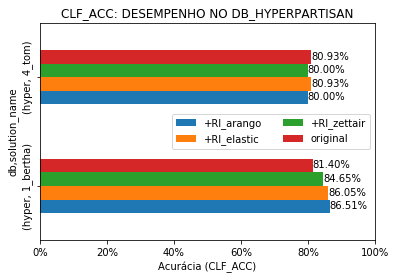

In [428]:
ax = fin.unstack().plot(kind='barh', y='accuracy')
ax.xaxis.set_major_formatter(PercentFormatter())
plt.title('CLF_ACC: DESEMPENHO NO DB_HYPERPARTISAN')
plt.xlabel('Acurácia (CLF_ACC)')
plt.legend(loc='best', ncol=2) #, bbox_to_anchor=(-0.02, 0.68))
plt.yticks(rotation=90, va="center")
plt.xlim(0.0, 100)
for p in ax.patches:
    # ax.annotate(p.get_height().astype('int64'), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(width/100), (x + width, y + 0.04))

    # ax.annotate(p.get_height().astype('int64'), (p.get_width(), p.get_y()+p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

figname = 'clf-acc-bars-hyperpartisan'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [429]:
df_4_tom = clf_acc_df.loc[(clf_acc_df['solution_name'] == '4_tom')]
# cre.loc[cre['f1_cv_10'].idxmax()]

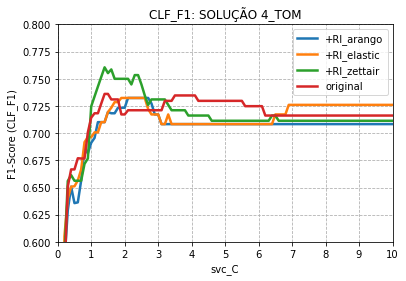

In [430]:
ax = cre.set_index('svc_C').groupby('exp_id').f1.plot(legend=True, lw=2.5)
plt.ylabel('F1-Score (CLF_F1)')
# plt.title('DB_HYPERPARTISAN: SOLUTION 2')
plt.title('CLF_F1: SOLUÇÃO 4_TOM')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_ylim(0.6, 0.80)

# ax[0].lines[3].set_linestyle('--')
# ax[0].lines[2].set_linestyle('-.')
# ax[0].lines[0].set_linestyle(':')
# ax[0].lines[2].set_linestyle(':')
# ax[0].lines[0].set_dashes([1, 1, 10, 2])
# ax[0].lines[1].set_dashes([1, 2 ])
# ax[0].lines[2].set_dashes([1, 2 ])
# ax[0].lines[3].set_dashes([1, 8 ])
figname = 'clf-f1-4-tom'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

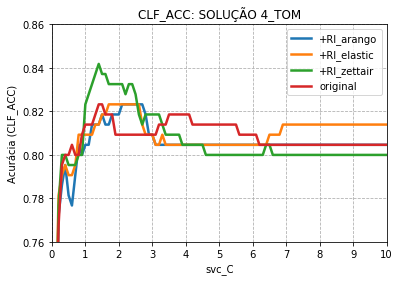

In [431]:
ax = cre.set_index('svc_C').groupby('exp_id').accuracy.plot(legend=True, lw=2.5)
plt.ylabel('Acurácia (CLF_ACC)')
plt.title('CLF_ACC: SOLUÇÃO 4_TOM')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_ylim(0.76, 0.86)

figname = 'clf-acc-4-tom'
plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=figdpi)
# plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight', dpi=50)
plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

Melhores valores de CLF_ACC e CLF_F1 para 4_tom

In [432]:
best_values = cre.loc[cre.groupby('tool').idxmax()['f1']]

best_values = best_values[['exp_run_type', 'svc_C', 'accuracy', 'f1']]
best_values

,exp_run_type,svc_C,accuracy,f1
18293,+RI_arango,2.1,0.823256,0.732394
18508,+RI_elastic,1.9,0.823256,0.732394
18060,original,1.4,0.823256,0.736111
18717,+RI_zettair,1.4,0.841860,0.760563


In [433]:
cre

,_key,_id,_rev,exp_id,variable,index_type,db,tool,db_name,value,...,svc_C,svc_max_iter,acc_train,acc_cv_10,f1_cv_10,use_scaler,use_only_ir_variables,scaler,use_scaler_only_ir,exp_run_type
18034,20200123-232811.095958,tcc_results/20200123-232811.095958,_Z7Tezry---,original,CLF_ACC,NaN,hyper,none,hyperpartisan_split_42_bulk,0.688372,...,0.1,5000,0.706977,0.669767,0.669767,NaN,NaN,NaN,NaN,original
18036,20200123-232812.051263,tcc_results/20200123-232812.051263,_Z7Te0ni---,original,CLF_ACC,NaN,hyper,none,hyperpartisan_split_42_bulk,0.767442,...,0.2,5000,0.797674,0.758140,0.758140,NaN,NaN,NaN,NaN,original
18038,20200123-232812.980539,tcc_results/20200123-232812.980539,_Z7Te1hm---,original,CLF_ACC,NaN,hyper,none,hyperpartisan_split_42_bulk,0.795349,...,0.3,5000,0.848837,0.774419,0.774419,NaN,NaN,NaN,NaN,original
18040,20200123-232813.891673,tcc_results/20200123-232813.891673,_Z7Te2ai---,original,CLF_ACC,NaN,hyper,none,hyperpartisan_split_42_bulk,0.800000,...,0.4,5000,0.862791,0.788372,0.788372,NaN,NaN,NaN,NaN,original
18042,20200123-232814.791954,tcc_results/20200123-232814.791954,_Z7Te3Sy---,original,CLF_ACC,NaN,hyper,none,hyperpartisan_split_42_bulk,0.800000,...,0.5,5000,0.872093,0.795349,0.795349,NaN,NaN,NaN,NaN,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18881,20200124-004713.188759,tcc_results/20200124-004713.188759,_Z7UnKom---,+RI_zettair,CLF_ACC,NaN,hyper,zettair,hyperpartisan_split_42_bulk,0.800000,...,9.6,5000,1,0.781395,0.781395,NaN,NaN,NaN,NaN,+RI_zettair
18883,20200124-004714.330475,tcc_results/20200124-004714.330475,_Z7UnLw----,+RI_zettair,CLF_ACC,NaN,hyper,zettair,hyperpartisan_split_42_bulk,0.800000,...,9.7,5000,1,0.781395,0.781395,NaN,NaN,NaN,NaN,+RI_zettair
18885,20200124-004715.467250,tcc_results/20200124-004715.467250,_Z7UnM3C---,+RI_zettair,CLF_ACC,NaN,hyper,zettair,hyperpartisan_split_42_bulk,0.800000,...,9.8,5000,1,0.781395,0.781395,NaN,NaN,NaN,NaN,+RI_zettair
18887,20200124-004716.625817,tcc_results/20200124-004716.625817,_Z7UnO_W---,+RI_zettair,CLF_ACC,NaN,hyper,zettair,hyperpartisan_split_42_bulk,0.800000,...,9.9,5000,1,0.781395,0.781395,NaN,NaN,NaN,NaN,+RI_zettair


(0.76, 3.5)

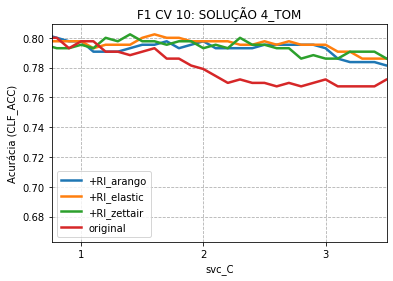

In [434]:
ax = cre.set_index('svc_C').groupby('exp_id').f1_cv_10.plot(legend=True, lw=2.5)
plt.ylabel('Acurácia (CLF_ACC)')
plt.title('F1 CV 10: SOLUÇÃO 4_TOM')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.76, 0.86)

ax[0].set_xlim(0.76, 3.5)
# ax[0].set_xlim(0.76, 2.5)

# figname = 'clf-acc-4-tom'
# plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight')
# plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

(0.76, 3.5)

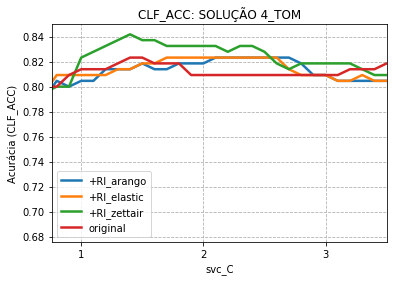

In [435]:
ax = cre.set_index('svc_C').groupby('exp_id').accuracy.plot(legend=True, lw=2.5)
plt.ylabel('Acurácia (CLF_ACC)')
plt.title('CLF_ACC: SOLUÇÃO 4_TOM')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.76, 0.86)
ax[0].set_xlim(0.76, 3.5)

# figname = 'clf-acc-4-tom'
# plt.savefig(f'{figfolder}/{figname}.png', bbox_inches='tight')
# plt.savefig(f'{figfolder}/{figname}-big.png', bbox_inches='tight',dpi=100)

In [436]:
ploting_with_scaler



,exp_id,classifier,train_final_score,accuracy,f1,tool,top_k,linear_svc_C,add_ir_variables,exp_run_type,ignore_first_result,perform_dimentionality_reduction,use_only_ir_variables,use_scaler
20312,original,LinearSVC,NaN,0.709474,0.746090,none,100,0.00001,False,original,False,True,False,False
20314,original,LinearSVC,NaN,0.715789,0.739884,none,100,0.00010,False,original,False,True,False,False
20316,original,LinearSVC,NaN,0.722632,0.729605,none,100,0.00100,False,original,False,True,False,False
20318,original,LinearSVC,NaN,0.728421,0.733471,none,100,0.00200,False,original,False,True,False,False
20320,original,LinearSVC,NaN,0.734211,0.738477,none,100,0.00500,False,original,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22654,+RI_zettair-MinMaxScaler,LinearSVC,NaN,0.807368,0.807773,zettair,100,9.60000,True,+RI_zettair,True,True,False,True
22656,+RI_zettair-MinMaxScaler,LinearSVC,NaN,0.807368,0.807773,zettair,100,9.70000,True,+RI_zettair,True,True,False,True
22658,+RI_zettair-MinMaxScaler,LinearSVC,NaN,0.807895,0.808399,zettair,100,9.80000,True,+RI_zettair,True,True,False,True
22660,+RI_zettair-MinMaxScaler,LinearSVC,NaN,0.807895,0.808399,zettair,100,9.90000,True,+RI_zettair,True,True,False,True
